In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
#import geopandas as gpd
from sklearn.preprocessing import StandardScaler
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# Load CSV files for 2019 and 2020 (use chunks for large files)
chunk_size = 5000
df_2019_chunks = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/2019_spatial_raw_master.csv", chunksize=chunk_size)
df_2019 = pd.concat(chunk for chunk in df_2019_chunks)
df_2020_chunks = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/2020_spatial_raw_master.csv", chunksize=chunk_size)
df_2020 = pd.concat(chunk for chunk in df_2020_chunks)

# Add year column for temporal analysis
df_2019['year'] = 2019
df_2020['year'] = 2020
df = pd.concat([df_2019, df_2020])

In [25]:
# Normalize numerical features (excluding spatial and categorical)
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Load spatial data with geopandas
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))
gdf['centroid'] = gdf.geometry.centroid
gdf['centroid_x'] = gdf.centroid.x
gdf['centroid_y'] = gdf.centroid.y

# Aggregate to LAD level (assuming LAD codes or boundaries are in the dataset)
lad_data = gdf.groupby('LSOA21NM').agg({    'centroid_x': 'mean', 'centroid_y': 'mean',
    'o_diabetes_quantity_per_capita': 'mean', 'o_opioids_quantity_per_capita': 'mean',
    'o_asthma_quantity_per_capita': 'mean', 'o_hypertension_quantity_per_capita': 'mean',
    'o_depression_quantity_per_capita': 'mean', 'o_anxiety_quantity_per_capita': 'mean'})  # Include all predictors/outcomes

In [4]:
df.shape

(67510, 169)

In [5]:
missing_values = df.isna().sum()

print(missing_values[missing_values > 0])

c_net annual income                                            1672
e_NO2                                                             2
e_ozone                                                           2
e_total_aerosol_optical_depth_at_550nm_surface                 3014
e_particulate_matter_d_less_than_25_um_surface                 3014
e_dewpoint_temperature_2m                                      2958
e_temperature_2m                                               2958
e_soil_temperature_level_1                                     2958
e_soil_temperature_level_3                                     2958
e_lake_bottom_temperature                                      2958
e_lake_mix_layer_depth                                         2958
e_lake_mix_layer_temperature                                   2958
e_lake_total_layer_temperature                                 2958
e_snow_albedo                                                  2958
e_snow_cover                                    

In [6]:
for col in df:
    if pd.api.types.is_numeric_dtype(df[col]):  # Check if column is numeric
        mean_value = df[col].mean()  # Calculate mean only for numeric columns
        df[col].fillna(mean_value, inplace=True)

<ipython-input-6-70355d67cdc3>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mean_value, inplace=True)


In [7]:
missing_values = df.isna().sum()

print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [8]:
target_variable = "o_total_quantity_per_capita"

X = df.drop(columns=['geography code','LSOA21NM','centroid_x','centroid_y','geometry', 'o_diabetes_quantity_per_capita', 'o_opioids_quantity_per_capita',
            'o_asthma_quantity_per_capita', 'o_hypertension_quantity_per_capita',
             'o_depression_quantity_per_capita', 'o_anxiety_quantity_per_capita'])
y = df[target_variable]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)


model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [9]:
# Feature Importance using Random Forest
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

In [10]:
feature_importance_df["Feature"][:20]

,Feature
156,o_total_quantity_per_capita
37,c_percent occupancy rating rooms +2
67,c_percent Aged 50 to 54 years
113,e_total_aerosol_optical_depth_at_550nm_surface
112,e_ozone
5,c_percent hindu
108,c_percent households deprived in four dimensions
29,c_percent student moved to address
126,e_snow_density
152,e_built


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt


# Select the top 20 important features + outcome
top_features = ["o_total_quantity_per_capita", "c_percent occupancy rating rooms +2", "c_percent Aged 50 to 54 years", "e_total_aerosol_optical_depth_at_550nm_surface", "e_ozone", "c_percent hindu",
                "c_percent households deprived in four dimensions", "c_percent student moved to address", "e_snow_density", "e_built", "c_percent mixed"]

df1 = df[top_features]

In [23]:
df1.describe()

,o_total_quantity_per_capita,c_percent occupancy rating rooms +2,c_percent Aged 50 to 54 years,e_total_aerosol_optical_depth_at_550nm_surface,e_ozone,c_percent hindu,c_percent households deprived in four dimensions,c_percent student moved to address,e_snow_density,e_built,c_percent mixed
count,67510.000000,67510.000000,67510.000000,67510.000000,67510.000000,67510.000000,67510.000000,67510.000000,67510.000000,67510.000000,67510.000000
mean,1162.407985,0.459403,0.069768,0.118743,323.708530,0.017045,0.002297,0.005366,108.134715,0.405779,0.028805
std,510.767288,0.182433,0.013772,0.006405,3.331947,0.039810,0.003299,0.018451,4.622999,0.195484,0.020556
min,0.484191,0.003817,0.000000,0.101983,317.979452,0.000000,0.000000,0.000000,100.019096,0.035278,0.000000
25%,905.781127,0.325969,0.061960,0.113982,320.609756,0.001256,0.000000,0.000889,105.202986,0.243201,0.013251
50%,1173.729584,0.470517,0.070346,0.119091,324.429487,0.004968,0.001370,0.001983,106.334873,0.447029,0.022906
75%,1470.747329,0.602692,0.078469,0.123160,327.015291,0.015951,0.003300,0.003579,109.298343,0.565274,0.039646
max,25611.093214,0.956857,0.148551,0.149654,329.265896,0.848455,0.050820,0.425776,128.402147,0.745675,0.185315


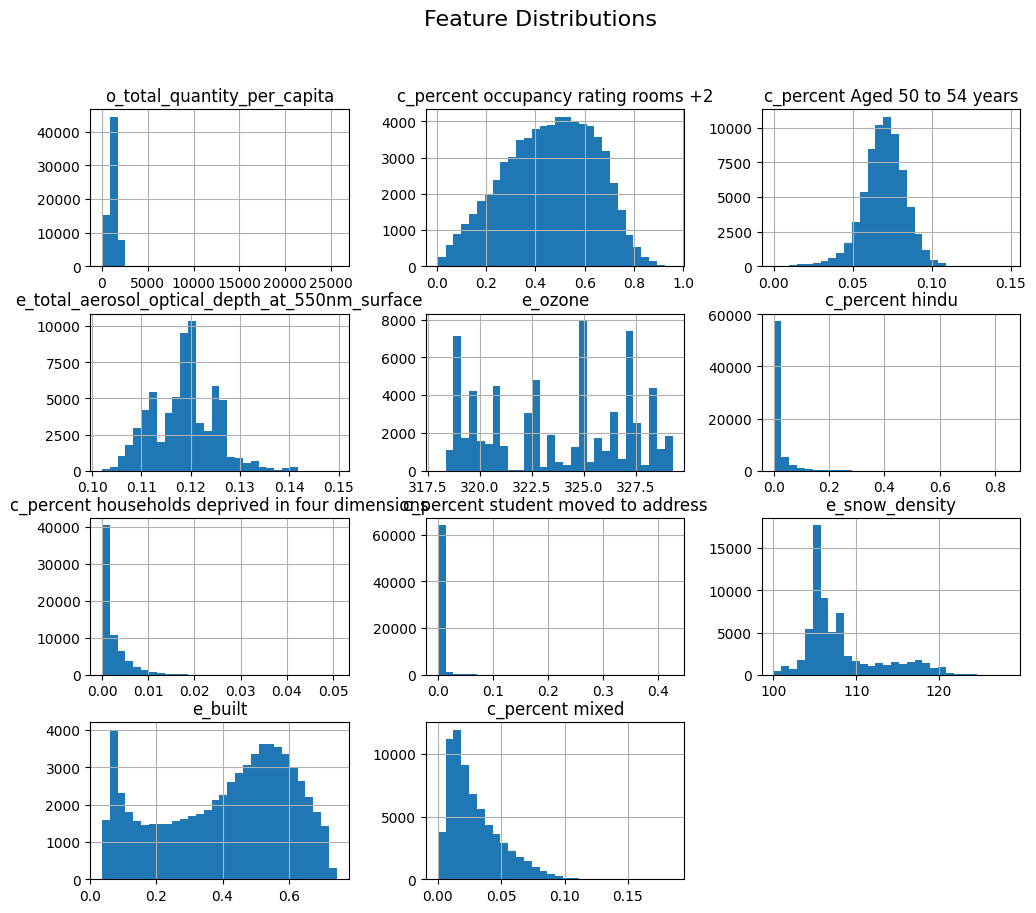

In [24]:
df1.hist(figsize=(12, 10), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

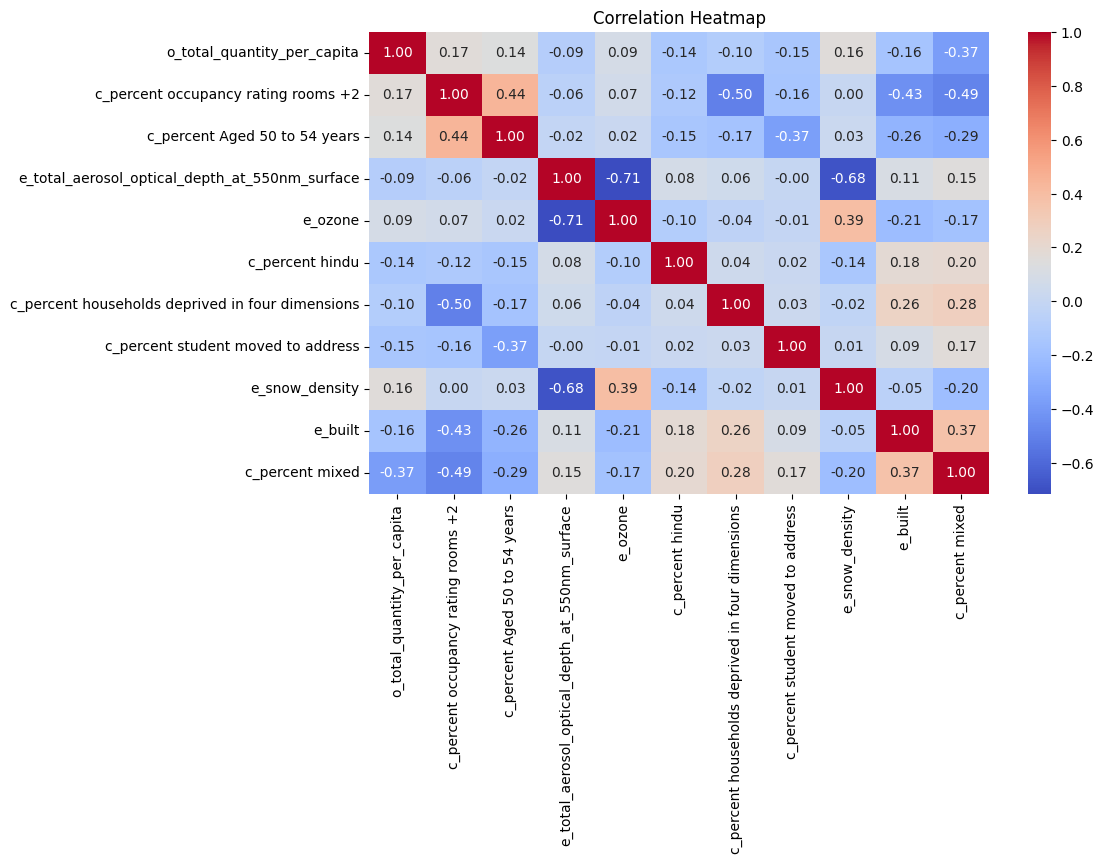

In [26]:
plt.figure(figsize=(10, 6))
sns.heatmap(df1.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()